In [1]:
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xesmf as xe
import cartopy.crs as ccrs

In [2]:
# set variable downloaded from the 20th century Reanalysis Data
vrbl = 'olr'

In [3]:
# User Configuration : Change these values to generate different datasets
if vrbl == 'pressure':
    var_name = 'z' # available: 't2m', 'tp', 'z'
    pressure_level = 500 # in hPa, ignored for variables without levels. available: 50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1,000
    region = 'northern_hemi' # available: 'global', 'europe', 'northern_hemi'
elif vrbl == 'sst': 
    var_name = 'sst' # available: 't2m', 'tp', 'z'
    region = 'mjo' # available: 'global', 'europe', 'northern_hemi'
    pressure_level = 500 # in hPa, ignored for variables without levels. available: 50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1,000
elif vrbl == 'olr': 
    var_name = 'olr' # available: 't2m', 'tp', 'z'
    region = 'mjo' # available: 'global', 'europe', 'northern_hemi'
    pressure_level = 500 # in hPa, ignored for variables without levels. available: 50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1,000
elif vrbl == 'pv':
    var_name = 'u' 
    pressure_level = 10 # in hPa, ignored for variables without levels. available: 50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1,000
    region = 'spv' # available: 'global', 'europe', 'northern_hemi'
yr30 = True #calculate 30 yr batch-wise climatology (WMO 2020) 
resolution = '1.40625' # in degrees, available: '5.625'
start_year, end_year = 1836, 1980 # set both to None to use all available years
reduce_to_single_dim = False # if True, the dataset will be reduced to a single dimension (time) by aggregating over the other dimensions
months_to_keep = [11, 12, 1, 2, 3]
start_season, end_season = '11-15', '03-31'

VISUALIZE = True # if True, the dataset will be visualized

In [4]:
# Configuration : Do not change these values
region_coords = {
    'europe': {'lat': slice(30, 50), 'lon': slice(-10, 20)},
    'northern_hemi': {'lat': slice(-10, 90)},
    'southern_hemi': {'lat': slice(-90, 10)},
    'spv': {'lat': slice(59,90)}, # z50 for Polar Vortex
    'mjo': {'lat': slice(-15,15)}, # t2m for MJO
    'global': None
}[region]
aggregate_func = {'sst': 'mean', 'u': 'mean', 'z': 'mean', 'olr': 'mean'}[var_name]
var_name_map = {'sst': 'air', 'z': 'hgt', 'u': 'uwnd','olr':'ulwrf'}
var_full = {'sst': 't2m', 'z': 'z', 'u': 'u','olr':'ulwrf'}
pressure_level = {'sst': '', 'u': pressure_level, 'z': pressure_level,'olr':''}[var_name]

In [5]:
def plot_examples(ds, examples=None):
    if isinstance(ds, xr.Dataset):
        ds = ds.to_array().squeeze()
    if examples is None:
        examples = np.random.choice(np.arange(len(ds.time)), 12)
    
    extent = (ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max())

    proj = ccrs.PlateCarree()
    fig, axes = plt.subplots(4, 3,figsize=(20, 20), subplot_kw={'projection': proj})
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.coastlines()
        p = ax.imshow(ds.isel(time=examples[i]), extent=extent, origin='lower', cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree())
        fig.colorbar(p, ax=ax, location='bottom')


In [6]:
# Load the data
full_data_path = Path(f'./raw/{var_name_map[var_name]}/{var_full[var_name]}_{pressure_level}_full.nc')
if not full_data_path.exists():
    ds = xr.open_mfdataset(f'./raw/{var_name_map[var_name]}/{var_name_map[var_name]}*.nc', combine='by_coords', engine ="netcdf4")
   
    # change longitude from 0-360 to -180-180 for extraction of europe
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    ds = ds.roll(lon=int(len(ds['lon']) / 2), roll_coords=True)
  
    # Select pressure level
    if 'level' in ds.dims:
        ds = ds.sel(level=pressure_level)
    else:
        pressure_level = ''
    
    try:
        ds = ds.drop('time_bnds')
    except ValueError:
        pass
    if vrbl == 't2m': 
        ds.air.encoding = {}
    elif vrbl == 'pv':
        ds.uwnd.encoding = {}
    elif vrbl == 'olr':
        ds.ulwrf.encoding = {}
    else:
        ds.hgt.encoding = {}
       
    ds.to_netcdf(full_data_path, engine ="netcdf4")
else:
    ds = xr.open_dataset(full_data_path)


examples = np.random.choice(np.arange(len(ds.time)), 12)

In [7]:
ds.ulwrf

<xarray.DataArray 'ulwrf' (time: 52961, lat: 181, lon: 360)>
[3450938760 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * time     (time) datetime64[ns] 1836-01-01 1836-01-02 ... 1980-12-31
Attributes: (12/13)
    long_name:         daily mean 3-hourly Upward Longwave Radiation Flux at ...
    units:             W/m^2
    GRIB_name:         ULWRF
    var_desc:          Upward Longwave Radiation Flux
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3si Dai...
    level_desc:        Surface
    ...                ...
    parent_stat:       Individual Obs
    valid_range:       [   0. 6553.]
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [111.24998 587.706  ]

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 31:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 476 in H5O__attr_open_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #006: H5Adense.c line 394 in H5A__dense_open(): can't locate attribute in name index
    major: Attribute
    minor: Object not

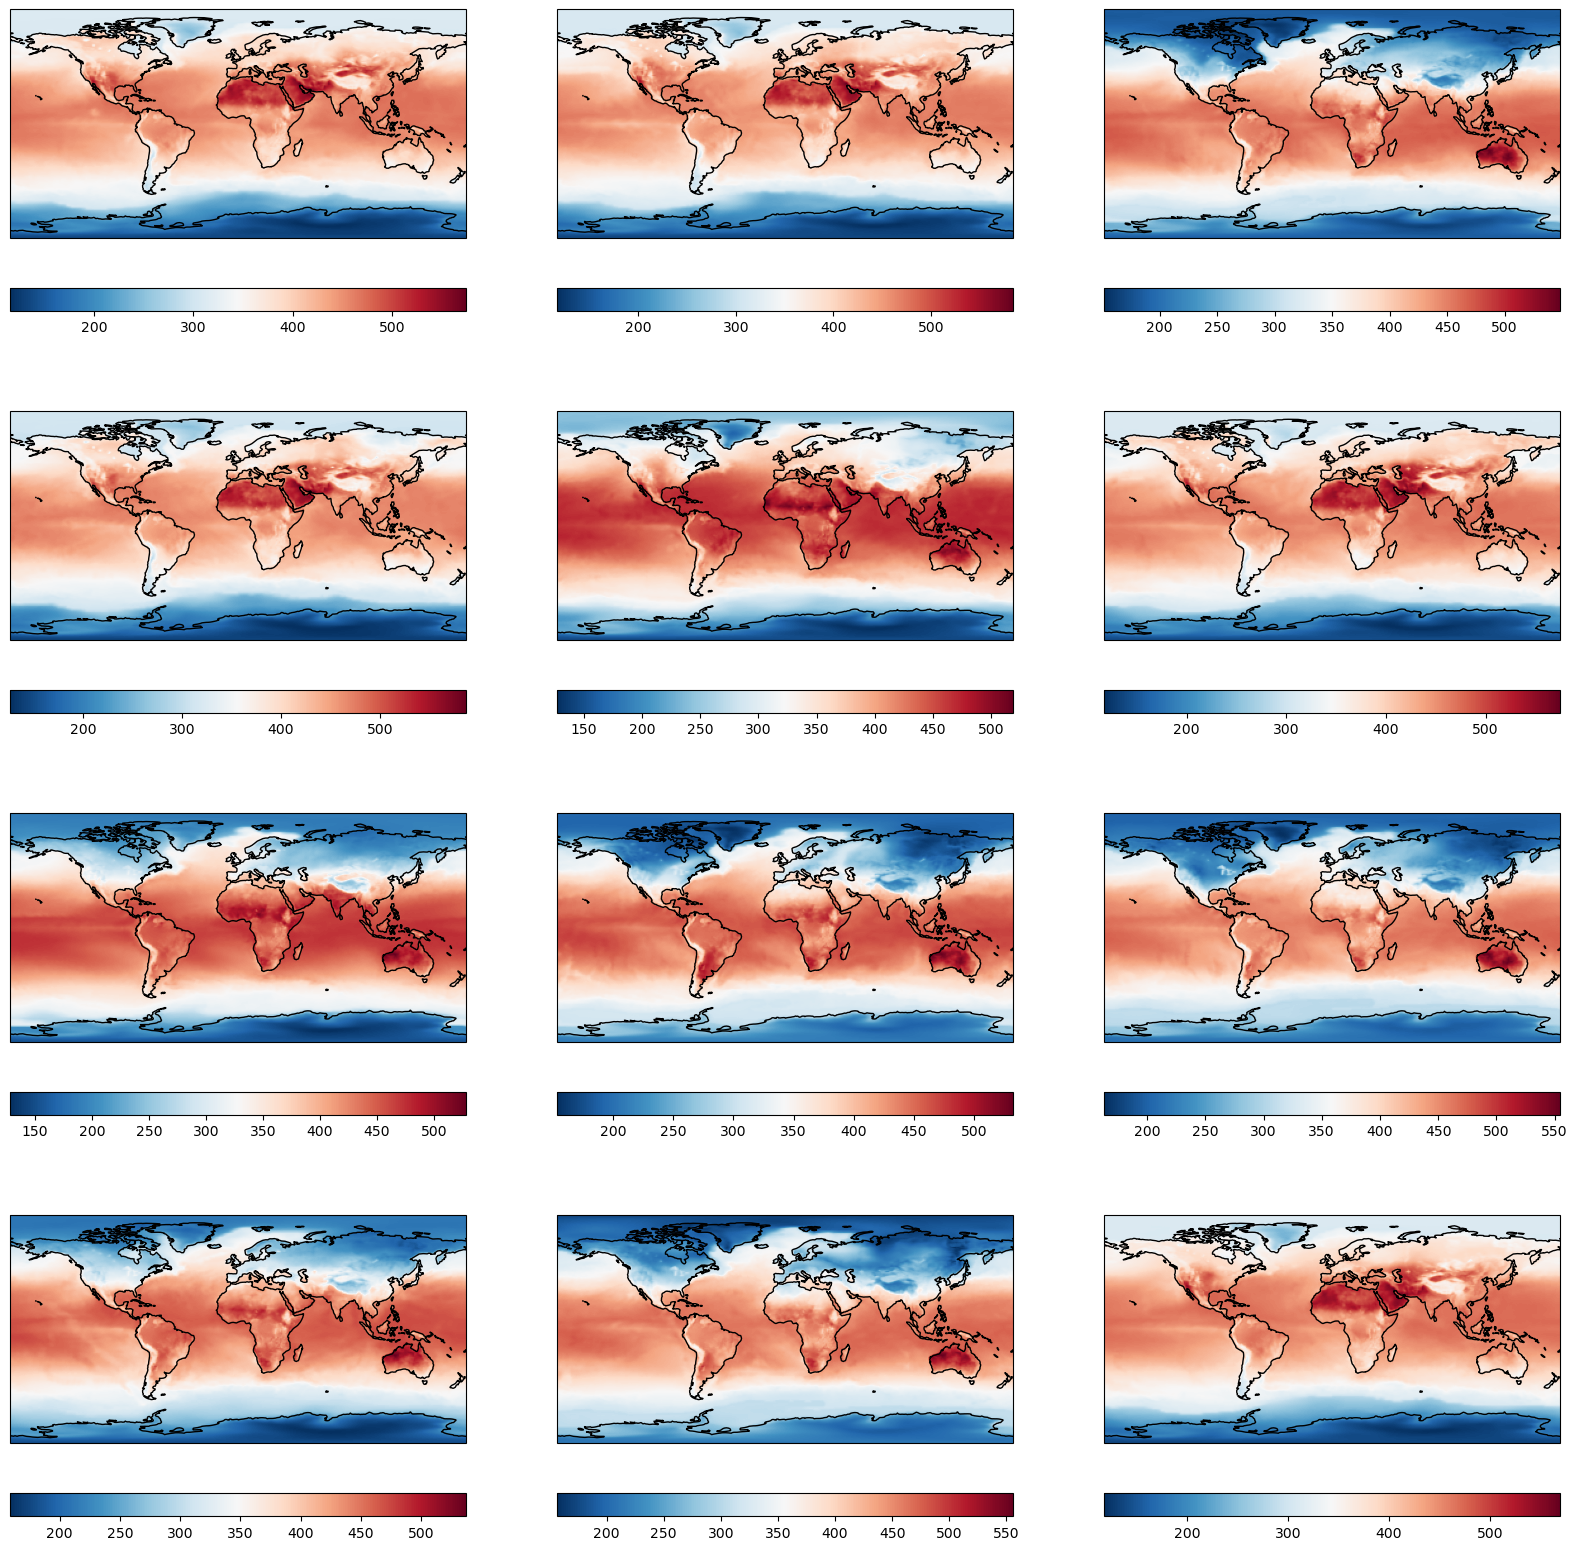

In [12]:
if VISUALIZE: 
    plot_examples(ds, examples=examples)

In [7]:
# regridding
grid_path = Path(f'../WeatherBench/{resolution}deg_grid.nc')
if grid_path.exists():
    grid = xr.load_dataset(grid_path)
    regridder = xe.Regridder(ds, grid, "bilinear")
    ds = regridder(ds[var_name_map[var_name]])
else:
    print('No grid found. Skipping regridding.')

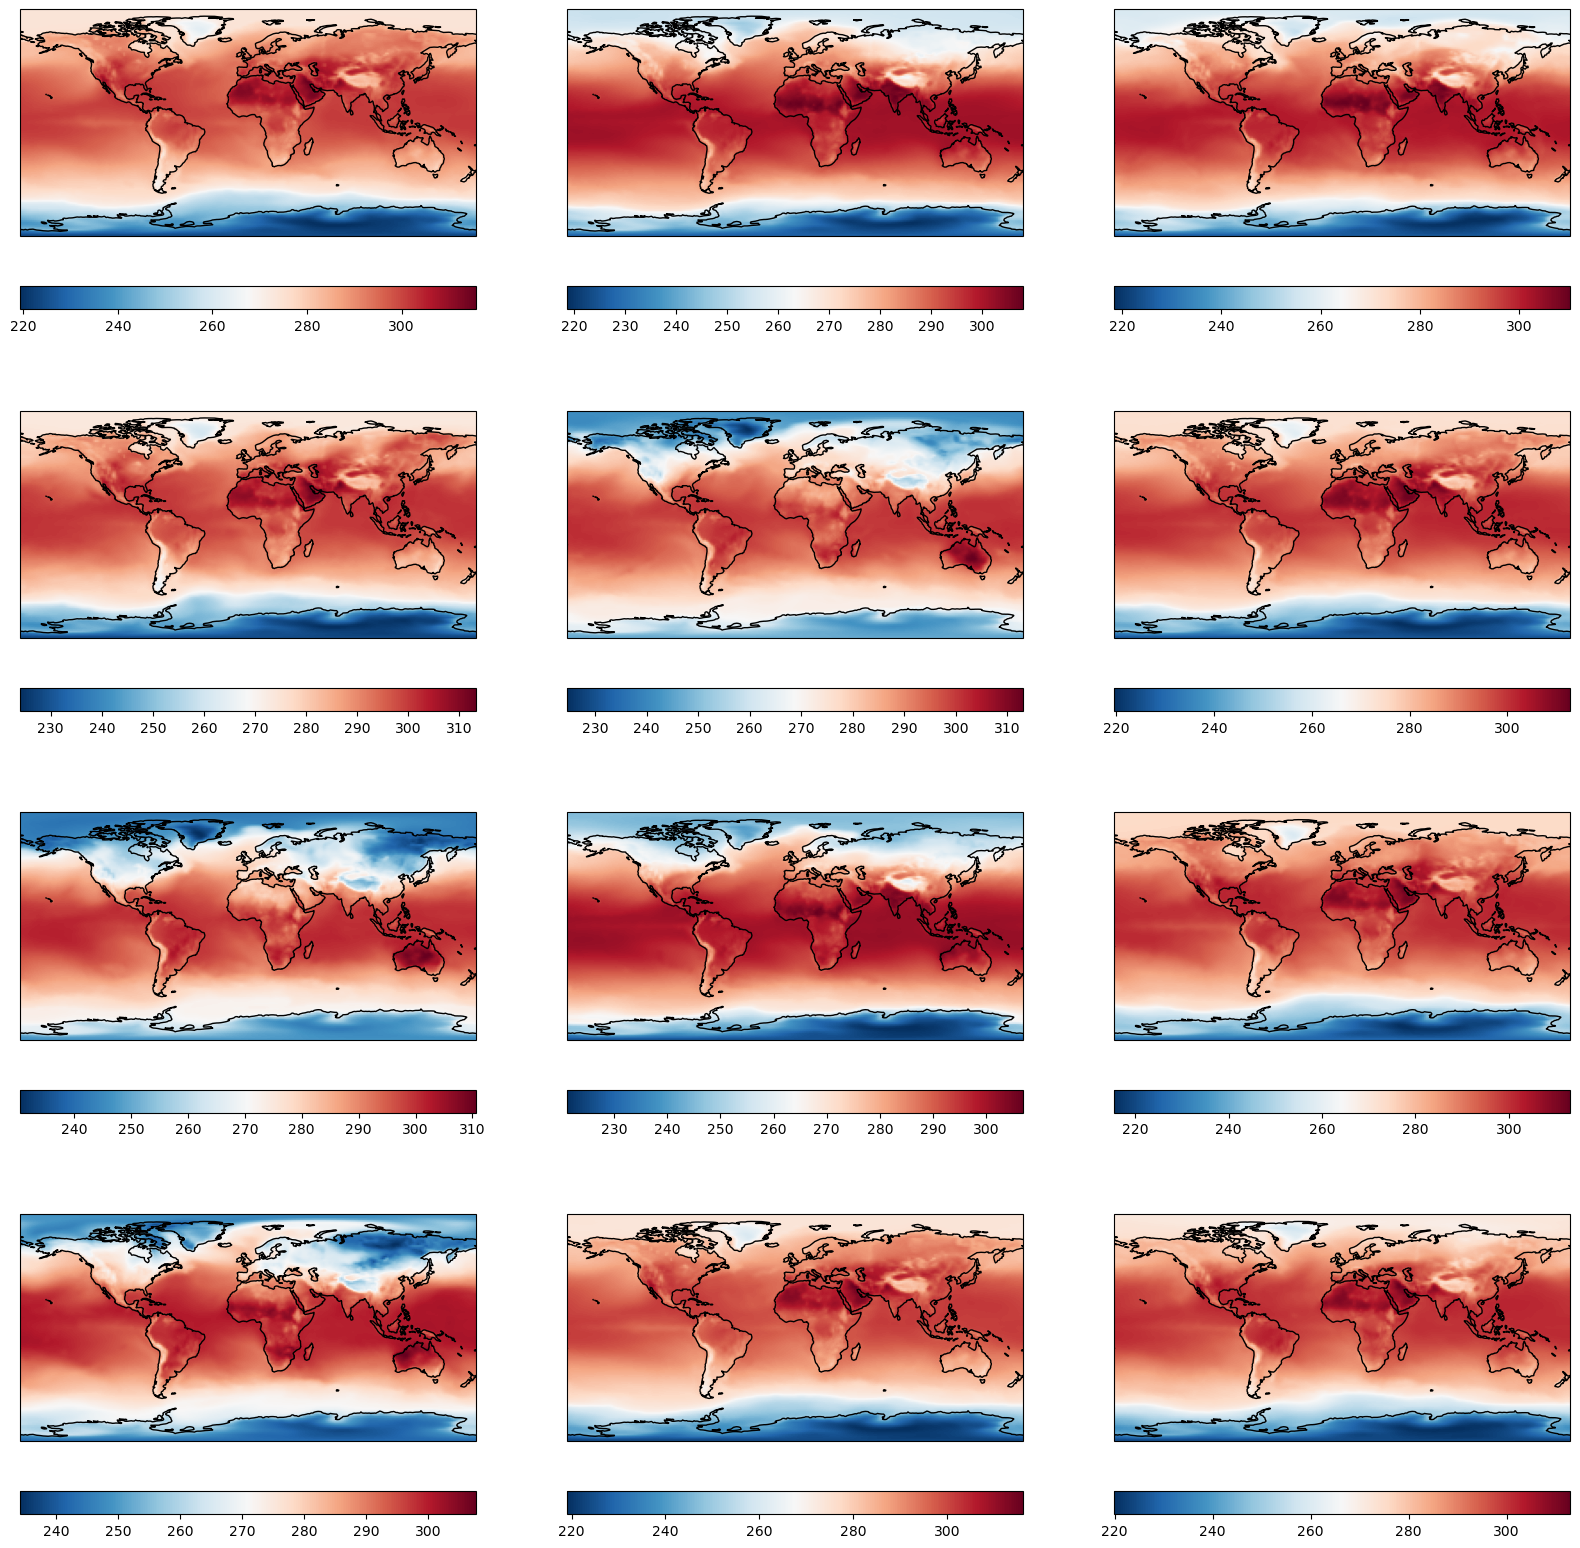

In [14]:
if VISUALIZE: 
    plot_examples(ds, examples=examples)

In [8]:
# Select years of interest
if start_year is not None:
    ds = ds.sel(time=slice(np.datetime64(f'{start_year}-01-01'), np.datetime64(f'{end_year}-12-31')))

# for naming purposes
if start_year is None:
    start_year = ds['time.year'].min().values
if end_year is None:
    end_year = ds['time.year'].max().values

In [9]:
# Select the region of interest
if region_coords:
    ds = ds.sel(**region_coords)

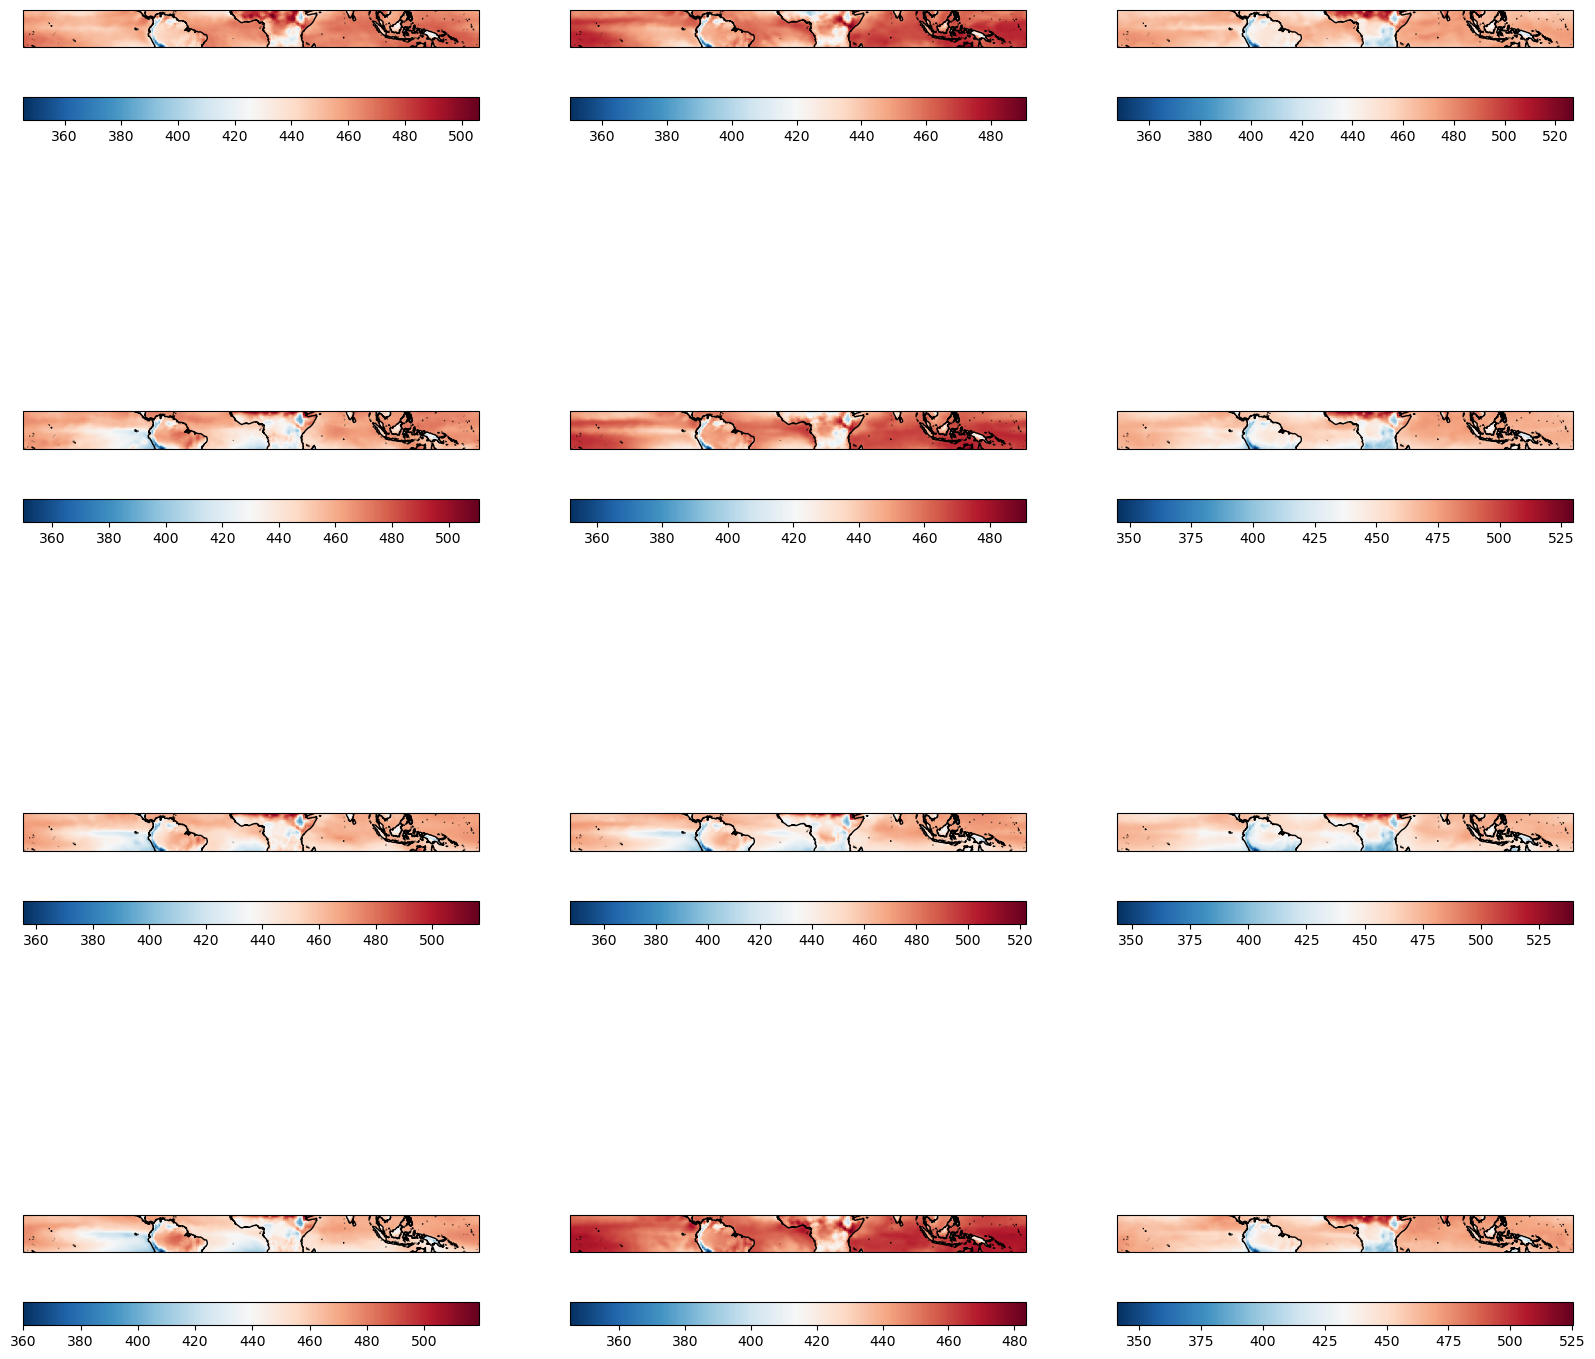

In [10]:
if VISUALIZE:
    examples = np.random.choice(np.arange(len(ds.time)), 12)
    plot_examples(ds, examples=examples)

In [11]:
# Compute climatology
from climatology import climatology_and_anomalies
climatology_folder = Path('./climatology')
climatology_folder.mkdir(exist_ok=True)

climatology_path = climatology_folder / Path(f'{var_name}_{resolution}deg_{pressure_level}_climatology.nc') 
if not climatology_path.exists():
    ds.groupby('time.dayofyear').mean('time').to_netcdf(climatology_path, engine ="netcdf4")

# Select the region and subtract climatology
yr30 = True
if yr30:
    ds = climatology_and_anomalies(ds, 30, f'./climatology/{var_name}_{resolution}deg_{pressure_level}_climatology_')
else:
    climatology = xr.open_dataset(climatology_path).__xarray_dataarray_variable__

    ds = ds.groupby('time.dayofyear') - climatology

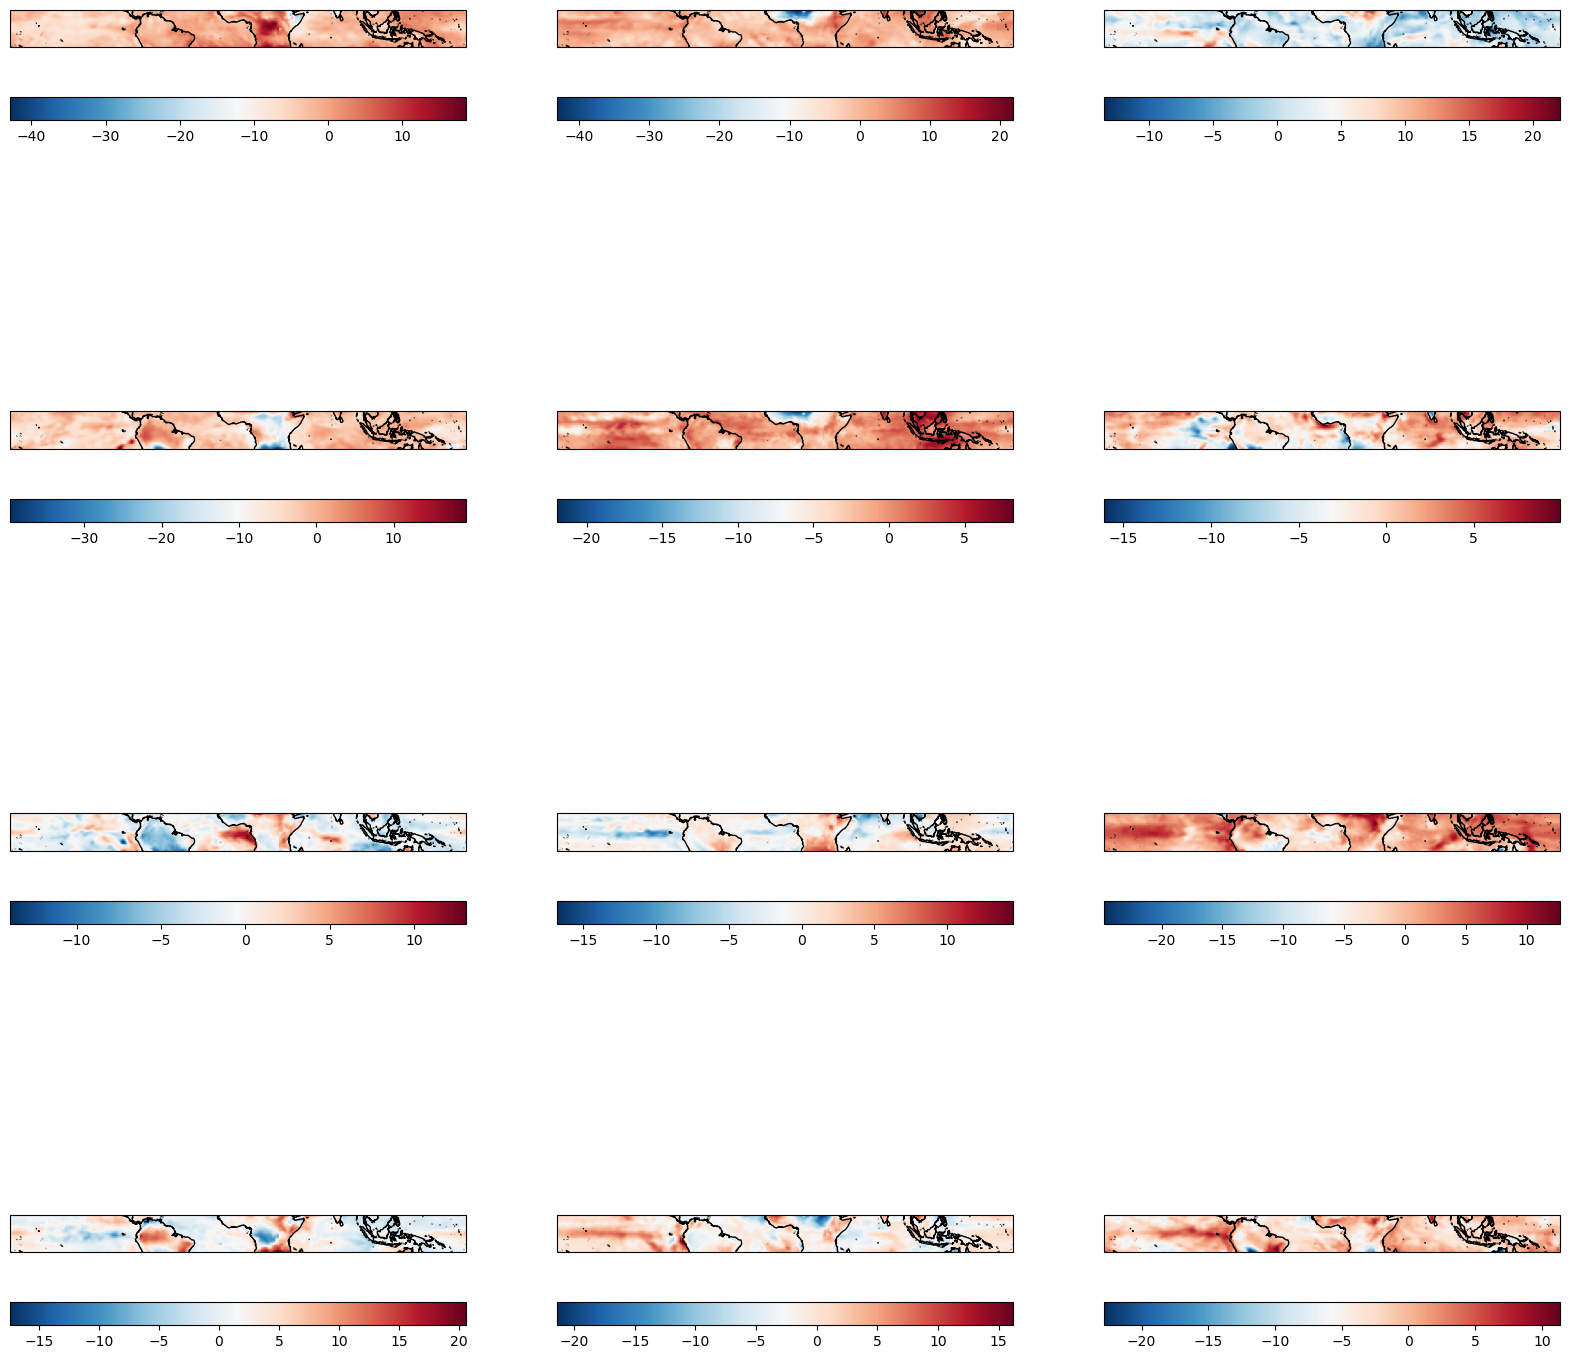

In [12]:
if VISUALIZE: 
    plot_examples(ds, examples=examples)

In [13]:
days = 7 # previously 5
time_len = len(ds.time.values)
time_coords = ds.time.values[:-days + 1]
if aggregate_func == 'mean':
    ds = ds.rolling(time=days).mean('time')
    ds = ds[{'time':slice((days-1),time_len)}].assign_coords(time=time_coords)
elif aggregate_func == 'sum':
    ds = ds.rolling(time=days).sum('time')
    ds = ds[{'time':slice((days-1),time_len)}].assign_coords(time=time_coords)

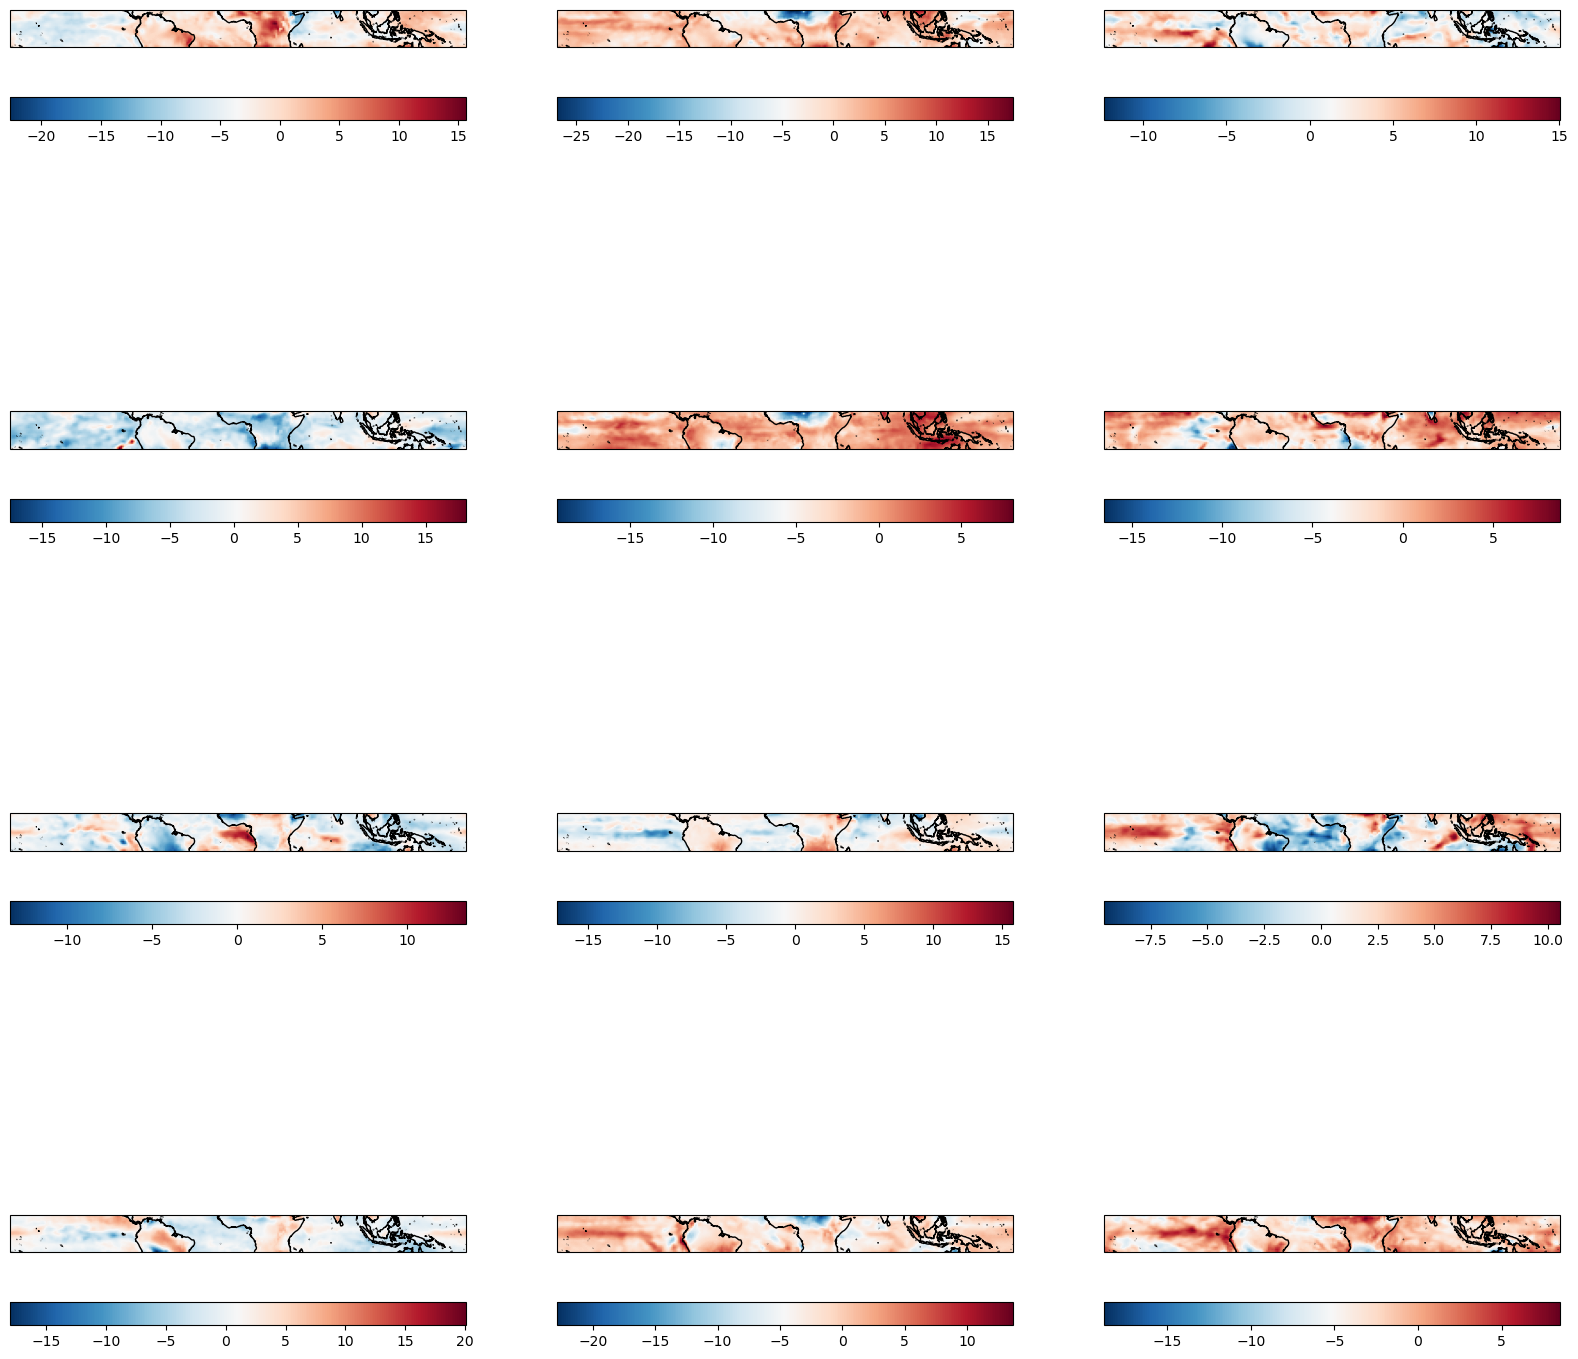

In [14]:
if VISUALIZE: 
    plot_examples(ds, examples=examples)

In [15]:
# compute seasons coordinates
yrs = np.arange(ds.isel(time=0).time.dt.year.values, ds.isel(time=-1).time.dt.year.values+1)
seas = []
for i in range(len(yrs)-1):
    year = yrs[i]
    ds_sel = ds.sel({'time':slice(np.datetime64(f'{year}-{start_season}'),np.datetime64(f'{year+1}-{end_season}'))})
    len_time = len(ds_sel.time.values)
    if i > 0:
        dst = xr.concat((dst,ds_sel), dim ='time')
        seas.append(len_time)
    if i ==0:
        seas = [len_time,len_time]
        dst = ds_sel
        del ds_sel
seas.append(len_time)
ds = dst
del ds_sel, dst

last = ds.isel(time=-1)
first = ds.isel(time=0)
seasons = seas
# cut days from first and last season that are not in dataset
cut_beginning = int((first.time.values - np.datetime64(f'{start_year - 1}-{start_season}')).astype(int) / (1e9 * 60 * 60 * 24))
cut_end = -1*int((last.time.values - np.datetime64(f'{end_year + 1}-{end_season}')).astype(int) / (1e9 * 60 * 60 * 24)) -7
seasons[0] -= cut_beginning
seasons[-1] -= cut_end

# add season coordinates along time dimension
season_coords = np.concatenate([s * [i] for i, s in enumerate(seasons)])
ds = ds.assign_coords(season=('time', season_coords))

In [68]:
if vrbl == 'sst': 
    mask  = xr.open_dataset('./raw/land.nc')
    regridder = xe.Regridder(mask, grid, "bilinear")
    mask = regridder(mask['land'])
    mask = mask.sel(**region_coords)
    mask = np.abs(mask -1)
    ds = ds.where(mask.squeeze(['time'], drop=True), np.nan)
#     ds = ds.rename({'land':'air'})
#     ds = ds.fillna(0)

In [69]:
if vrbl == 'sst':
    ds = ds.fillna(0)

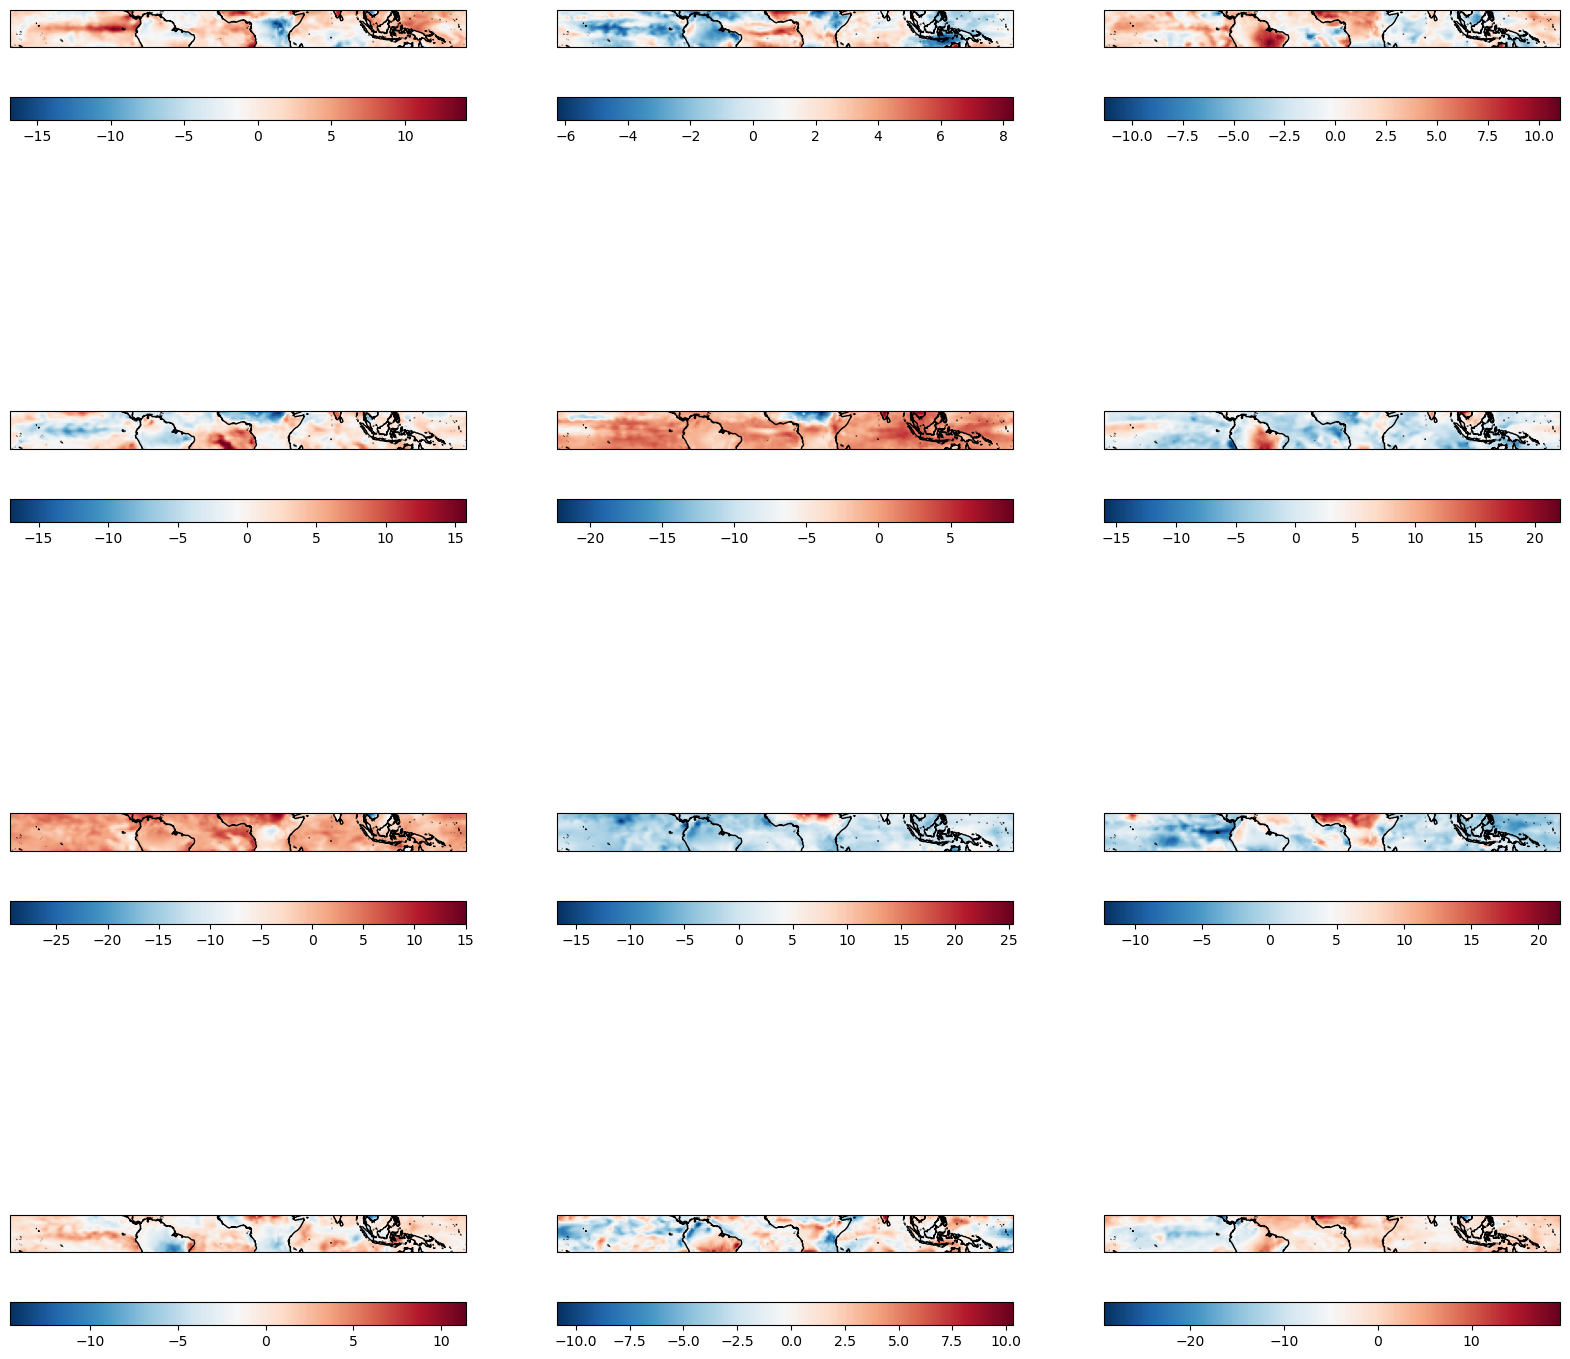

In [16]:
if VISUALIZE:
    examples = np.random.choice(np.arange(len(ds.time)), 12)
    plot_examples(ds, examples=examples)

In [17]:
# Save.
dataset_dir = Path('./datasets')
dataset_dir.mkdir(exist_ok=True)

file_name = dataset_dir / Path(f'{var_name}_{pressure_level}_{resolution}deg_{start_year}-{end_year}_{region}_{"1d" if reduce_to_single_dim else "2d"}.nc')

ds.to_netcdf(file_name, engine ="netcdf4")

In [72]:
if reduce_to_single_dim:
    ds = ds.stack(lattice =['lat', 'lon'])

In [73]:
ds

<xarray.DataArray (time: 19763, lat: 22, lon: 256)>
array([[[ 2.6142783 ,  2.7061918 ,  2.7943356 , ...,  2.3244271 ,
          2.4234586 ,  2.5196888 ],
        [ 3.1937056 ,  3.3131776 ,  3.4225519 , ...,  2.8286078 ,
          2.95023   ,  3.0737386 ],
        [ 3.6975894 ,  3.8281007 ,  3.9616652 , ...,  3.2881474 ,
          3.4185357 ,  3.558099  ],
        ...,
        [ 4.5982842 ,  4.513393  ,  4.429538  , ...,  4.8249536 ,
          4.755466  ,  4.6783047 ],
        [ 4.203857  ,  4.112822  ,  4.0119967 , ...,  4.4714847 ,
          4.3844066 ,  4.2905436 ],
        [ 3.7240603 ,  3.6209059 ,  3.5126019 , ...,  4.0228844 ,
          3.9293346 ,  3.8272815 ]],

       [[ 1.6627221 ,  1.7599728 ,  1.847735  , ...,  1.3778069 ,
          1.4736094 ,  1.5673641 ],
        [ 2.1327455 ,  2.246364  ,  2.349775  , ...,  1.804803  ,
          1.9100461 ,  2.0211692 ],
        [ 2.559063  ,  2.6740453 ,  2.7988393 , ...,  2.202635  ,
          2.3160543 ,  2.433475  ],
...
        [-4.743169  , -4.733085  , -4.7156615 , ..., -4.7627015 ,
         -4.760443  , -4.7525015 ],
        [-4.145262  , -4.1553946 , -4.150726  , ..., -4.1328735 ,
         -4.1499085 , -4.1496315 ],
        [-3.4390457 , -3.4528868 , -3.4658628 , ..., -3.385053  ,
         -3.4101858 , -3.4234228 ]],

       [[ 5.0903177 ,  5.0701933 ,  5.0445404 , ...,  5.1085806 ,
          5.1064787 ,  5.098167  ],
        [ 4.717117  ,  4.708152  ,  4.693178  , ...,  4.692785  ,
          4.7078753 ,  4.715036  ],
        [ 4.2760406 ,  4.2675486 ,  4.257172  , ...,  4.21764   ,
          4.2349143 ,  4.2577252 ],
        ...,
        [-3.7065852 , -3.7113304 , -3.7073185 , ..., -3.6902585 ,
         -3.7006326 , -3.7042022 ],
        [-3.3308723 , -3.3488367 , -3.352404  , ..., -3.2875085 ,
         -3.3119256 , -3.3215282 ],
        [-2.8648465 , -2.887316  , -2.9092627 , ..., -2.7877192 ,
         -2.8190396 , -2.842639  ]]], dtype=float32)
Coordinates:
    level    float32 10.0
  * time     (time) datetime64[ns] 1836-11-15 1836-11-16 ... 1980-03-31
  * lat      (lat) float64 59.77 61.17 62.58 63.98 ... 85.08 86.48 87.89 89.3
  * lon      (lon) float64 -180.0 -178.6 -177.2 -175.8 ... 175.8 177.2 178.6
    season   (time) float64 1.0 1.0 1.0 1.0 1.0 ... 144.0 144.0 144.0 144.0
Attributes:
    regrid_method:  bilinear

In [74]:
# dataset_dir = Path('./datasets')
# dataset_dir.mkdir(exist_ok=True)

# file_name = dataset_dir / Path(f'{var_name}_{pressure_level}_{resolution}deg_{start_year}-{end_year}_{region}_{"1d" if reduce_to_single_dim else "2d"}.nc')

# ds.to_netcdf(file_name, engine ="netcdf4")

In [75]:
xr.load_dataarray(file_name, engine ="netcdf4")

<xarray.DataArray (time: 19763, lat: 22, lon: 256)>
array([[[ 2.6142783 ,  2.7061918 ,  2.7943356 , ...,  2.3244271 ,
          2.4234586 ,  2.5196888 ],
        [ 3.1937056 ,  3.3131776 ,  3.4225519 , ...,  2.8286078 ,
          2.95023   ,  3.0737386 ],
        [ 3.6975894 ,  3.8281007 ,  3.9616652 , ...,  3.2881474 ,
          3.4185357 ,  3.558099  ],
        ...,
        [ 4.5982842 ,  4.513393  ,  4.429538  , ...,  4.8249536 ,
          4.755466  ,  4.6783047 ],
        [ 4.203857  ,  4.112822  ,  4.0119967 , ...,  4.4714847 ,
          4.3844066 ,  4.2905436 ],
        [ 3.7240603 ,  3.6209059 ,  3.5126019 , ...,  4.0228844 ,
          3.9293346 ,  3.8272815 ]],

       [[ 1.6627221 ,  1.7599728 ,  1.847735  , ...,  1.3778069 ,
          1.4736094 ,  1.5673641 ],
        [ 2.1327455 ,  2.246364  ,  2.349775  , ...,  1.804803  ,
          1.9100461 ,  2.0211692 ],
        [ 2.559063  ,  2.6740453 ,  2.7988393 , ...,  2.202635  ,
          2.3160543 ,  2.433475  ],
...
        [-4.743169  , -4.733085  , -4.7156615 , ..., -4.7627015 ,
         -4.760443  , -4.7525015 ],
        [-4.145262  , -4.1553946 , -4.150726  , ..., -4.1328735 ,
         -4.1499085 , -4.1496315 ],
        [-3.4390457 , -3.4528868 , -3.4658628 , ..., -3.385053  ,
         -3.4101858 , -3.4234228 ]],

       [[ 5.0903177 ,  5.0701933 ,  5.0445404 , ...,  5.1085806 ,
          5.1064787 ,  5.098167  ],
        [ 4.717117  ,  4.708152  ,  4.693178  , ...,  4.692785  ,
          4.7078753 ,  4.715036  ],
        [ 4.2760406 ,  4.2675486 ,  4.257172  , ...,  4.21764   ,
          4.2349143 ,  4.2577252 ],
        ...,
        [-3.7065852 , -3.7113304 , -3.7073185 , ..., -3.6902585 ,
         -3.7006326 , -3.7042022 ],
        [-3.3308723 , -3.3488367 , -3.352404  , ..., -3.2875085 ,
         -3.3119256 , -3.3215282 ],
        [-2.8648465 , -2.887316  , -2.9092627 , ..., -2.7877192 ,
         -2.8190396 , -2.842639  ]]], dtype=float32)
Coordinates:
    level    float32 10.0
  * time     (time) datetime64[ns] 1836-11-15 1836-11-16 ... 1980-03-31
  * lat      (lat) float64 59.77 61.17 62.58 63.98 ... 85.08 86.48 87.89 89.3
  * lon      (lon) float64 -180.0 -178.6 -177.2 -175.8 ... 175.8 177.2 178.6
    season   (time) float64 1.0 1.0 1.0 1.0 1.0 ... 144.0 144.0 144.0 144.0
Attributes:
    regrid_method:  bilinear